# CNN Calibration

This notebook shows the whole implementation and simulation of « Calibrating Rough Volatility Models：A Convolutional Neural Network Approach » by Henry STONE.

The idea is to use a 1D CNN to predict the Hölder exponent $H$ of a stochastic process.

In [1]:
import time
import logging
import numpy as np
import pandas as pd
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
import tensorflow as tf
import keras as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [3]:
from fbm import FBM

In [4]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [5]:
def generating_rBergomi_path(n_paths, n_timesteps, H, T=1, eta=1):
    """Generates rough Bergomi paths with specific parameters.
    Source: https://github.com/amuguruza/RoughFCLT/blob/master/rDonsker.ipynb
    
    Parameters:
    -----------
        n_timesteps: number of time steps of the path points
        n_paths: number of paths to generate
        H: Hurst Index
        T: time horizon
        eta: parameter eta
    Returns:
    --------
        paths: 2D-array, shape [n_paths, n_timesteps]
        
    """
    assert 0 < H < 1.0
    
    ## Step1: create partition 
    steps = np.linspace(0, 1, num=n_timesteps)[1:]   
    ## Step 2: compute covariance matrix
    cov = np.zeros((n_timesteps-1, n_timesteps-1))
    for i in range(cov.shape[0]):
        cov[i, i] = np.power(steps[i], 2*H) / (2 * H)
        for j in range(i+1, cov.shape[1]):
            s, t = steps[i], steps[j]
            cov[i, j] = np.power(t-s, H-0.5) / (H + 0.5) * np.power(s, 0.5+H) * special.hyp2f1(0.5-H, 0.5+H, 1.5+H, -s/(t-s))
            cov[j, i] = cov[i, j]
        
    ## Step 3: compute Cholesky decomposition    
    P = np.linalg.cholesky(cov) # shape [n_timesteps-1, n_timesteps-1]   
    ## Step 4: draw Gaussian rv
    Z = np.random.normal(loc=0.0, scale=1.0, size=[n_paths, n_timesteps-1])   
    ## Step 5: get V
    W = Z.dot(P.T) # shape [n_paths, n_timesteps-1]     
    # Use self-similarity to extend to [0,T] 
    paths = W * np.power(T, H) * eta * np.sqrt(2*H)
    # insert an all-0 column at the beginning
    paths = np.insert(paths, 0, 0, axis=1) # shape [n_paths, n_timesteps]
    return paths

def generating_rBergomi_random(n_paths, n_timesteps=100):
    """Generates n_paths trajectories of the Z process in the rBergomi model with parameters
    eta ~ Uniform([0,3]) and H ~ Beta(1, 9) for each trajectory
    
    Parameters:
    -----------
        n_paths: number of paths to generate
        n_timesteps: number of time steps in a path
    
    Returns:
    --------
        paths: 2D-array, shape [n_paths, n_timesteps]
        
    """
    etas = np.random.uniform(0, 3, n_paths)
    Hs = np.random.beta(1, 9, n_paths)
    paths = np.zeros((n_paths, n_timesteps), dtype=float)
    paths = np.array([generating_rBergomi_path(1, n_timesteps, Hs[i], 1, etas[i])[0] for i in range(n_paths)])
    assert paths.shape == (n_paths, n_timesteps)
    return paths, Hs, etas

def lagged_mean(path, q, lag):
    """Computes the mean of the q-powered lagged path
    
    Parameters:
    -----------
        path: 1D-array, the path
        q: the power
        lag: number of steps to lag
    """
    return np.mean(np.power(np.abs(path[lag:]-path[:-lag]), q))

def least_squares_helper(q, logs, path):
    avgs = [lagged_mean(path, q, lag) for lag in range(1, 31)]
    avgs_log = np.log(avgs)
    return np.polyfit(logs, avgs_log, 1)[0]

def least_squares_path(path):
    powers = [0.5, 1.0, 1.5, 2.0, 3.0]
    logs = np.log(np.arange(1, 31))
    K_q = [least_squares_helper(q, logs, path) for q in powers]
    return np.polyfit(powers, K_q, 1)[:2]

def least_squares(paths):
    return np.apply_along_axis(least_squares_path, 1, paths.reshape(paths.shape[:2]))

In [6]:
def generating_H(how='discretized'):
    """ Different samplers of H
    """
    if how == 'discretized':
        return [0.1, 0.2, 0.3, 0.4, 0.5]
    elif how == 'uniform':
        return list(np.random.rand(5) * 0.5)
    elif how == 'beta':
        return list(np.random.beta(1, 9, 5))
    else:
        raise ValueError("No such method to generate H's")

def joint_shuffle(a, b):
    """ Randomly shuffle two arrays jointly
    """
    assert len(a) == len(b)
    shuffle_idx = np.random.permutation(np.arange(len(a)))
    return a[shuffle_idx], b[shuffle_idx]

In [7]:
def build_nn(input_length=100, kernel_size=20, pool_size=3, leaky_rate=0.1, output_length=1):
    """ Builds the Neural Network architechture.
    """
    model = K.models.Sequential([
        K.layers.Conv1D(32, kernel_size, activation='linear', padding='same', input_shape=(input_length, 1)),
        K.layers.LeakyReLU(alpha=leaky_rate),
        K.layers.MaxPool1D(pool_size, padding='same'),
        K.layers.Dropout(rate=0.25),
        K.layers.Conv1D(64, kernel_size, activation='linear', padding='same'),
        K.layers.LeakyReLU(alpha=leaky_rate),
        K.layers.MaxPool1D(pool_size, padding='same'),
        K.layers.Dropout(rate=0.25),
        K.layers.Conv1D(128, kernel_size, activation='linear', padding='same'),
        K.layers.LeakyReLU(alpha=leaky_rate),
        K.layers.MaxPool1D(pool_size, padding='same'),
        K.layers.Dropout(rate=0.4),
        K.layers.Flatten(),
        K.layers.Dense(128, activation='linear'),
        K.layers.LeakyReLU(alpha=leaky_rate),
        K.layers.Dropout(rate=0.3),
        K.layers.Dense(output_length, activation='sigmoid')
    ])
    return model

In [8]:
def shuffle_split_data(paths, labels):
    """ Shuffles a dataset and splits it into train/val/test
    """
    paths, labels = joint_shuffle(paths, labels)
    paths = paths.reshape((paths.shape[0], paths.shape[1], 1))
    labels = labels.reshape((labels.shape[0], -1))
    
    X_train, X_test, Y_train, Y_test = train_test_split(paths, labels, test_size=0.3)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

def prepare_data(Hs, method='rbergomi', n_paths=5000, n_timesteps=500, T=1, eta=1):
    """ Prepares dataset for neural network. 
    1. Generate paths
    2. Shuffle and split dataset into train/val/test
    """
    paths = np.zeros((n_paths*len(Hs), n_timesteps), dtype=float)
    labels = np.zeros(n_paths*len(Hs), dtype=float)
    
    if method == 'rbergomi':
        for H_idx, H in enumerate(Hs):
            paths[H_idx*n_paths:(H_idx+1)*n_paths, :] = generating_rBergomi_path(n_paths, n_timesteps, H, T, eta)
            labels[H_idx*n_paths:(H_idx+1)*n_paths] = H
    elif method == 'fbm':
        for H_idx, H in enumerate(Hs):
            labels[H_idx*n_paths:(H_idx+1)*n_paths] = H
            path_generator = FBM(n=n_timesteps-1, hurst=H, length=T, method='cholesky')
            for i in range(n_paths):
                paths[H_idx*n_paths+i, :] = path_generator.fbm()
    
    return shuffle_split_data(paths, labels)

In [9]:
def benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test, kernel_size=20, pool_size=3, leaky_rate=0.3, 
              batch_size=64, n_epochs=30, verbose=0, time_steps=[100, 200, 300, 400, 500]):
    """ The whole training and evaluation procedure of the CNN
    """
    report = pd.DataFrame(columns=['RMSE(CNN)', 'MRE(CNN)', 'Training Time (seconds)', 'Test Time (seconds)', 
                                   'RMSE(LS)', 'MRE(LS)', 'Time (seconds)'], index=time_steps)
    report.index.name = 'Input length'
    loss_history = {}
    
    for n_timesteps in time_steps:
        logging.info("Performing paths of {} time steps".format(n_timesteps))

        start_time = time.time()
        model = build_nn(n_timesteps, kernel_size, pool_size, leaky_rate)
        model.compile(optimizer='adam', loss='mean_squared_error')

        X_train_t = X_train[:, :n_timesteps]
        X_val_t = X_val[:, :n_timesteps]
        X_test_t = X_test[:, :n_timesteps]
        
        logging.info("Running CNN")
        early_stopping = EarlyStopping(monitor='val_loss', patience=n_epochs, verbose=verbose, 
                                       mode='auto', restore_best_weights=False)
        cnn_train = model.fit(X_train_t, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=verbose, 
                              validation_data=(X_val_t, Y_val), callbacks=[early_stopping])

        cnn_train_time = time.time() - start_time
        report.loc[n_timesteps, 'Training Time (seconds)'] = cnn_train_time
        start_time = time.time()

        cnn_pred = model.predict(X_test_t)
        cnn_test_time = time.time() - start_time
        report.loc[n_timesteps, 'Test Time (seconds)'] = cnn_test_time
        report.loc[n_timesteps, 'RMSE(CNN)'] = np.sqrt(np.mean(np.power(cnn_pred-Y_test, 2)))
        report.loc[n_timesteps, 'MRE(CNN)'] = np.mean(np.abs(cnn_pred-Y_test) / Y_test)
        
        loss_history[n_timesteps] = {
            'train_loss': cnn_train.history['loss'],
            'val_loss': cnn_train.history['val_loss']
        }

        logging.info("Running Least Squares")
        start_time = time.time()
        ls_pred = least_squares(X_test_t)[:, 0]
        report.loc[n_timesteps, 'Time (seconds)'] = time.time() - start_time
        report.loc[n_timesteps, 'RMSE(LS)'] = np.sqrt(np.mean(np.power(ls_pred-Y_test, 2)))
        report.loc[n_timesteps, 'MRE(LS)'] = np.mean(np.abs(ls_pred-Y_test) / Y_test)

    return report, loss_history

In [10]:
def plot_learning_curves(loss_history, title_prefix=''):
    """ Plots learning curves with train_loss and val_loss
    """
    n_plots = len(loss_history)
    nrows = int(np.ceil(n_plots / 2))
    plt.figure(figsize=(12, nrows*4))
    for plot_idx, (title_suffix, losses) in enumerate(loss_history.items()):
        plt.subplot(nrows, 2, plot_idx+1)
        plt.plot(losses['train_loss'], color='b', marker='s', label='training loss', alpha=0.6)
        plt.plot(losses['val_loss'], color='r', marker='o', label='validation loss', alpha=0.6)
        plt.xlabel('Epochs')
        plt.ylabel('Mean Squared Loss')
        plt.title('{} = {}'.format(title_prefix, title_suffix))
        plt.legend(loc=1)
    plt.tight_layout()
    plt.show()   

# Discretized H

In this section, $H$ is discretized fixed values: [0.1, 0.2, 0.3, 0.4, 0.5]

Prepare dataset

In [11]:
T = 1
n_timesteps = 500
n_paths = 5000

Hs = generating_H(how='discretized')
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_data(Hs, 'rbergomi', n_paths, n_timesteps, T)

Train CNN and evaluate

In [12]:
kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

report, loss_history = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test, 
                                 kernel_size, pool_size, leaky_rate, batch_size, n_epochs)

2019-04-14 01:32:42,294 - INFO - Performing paths of 100 time steps
2019-04-14 01:32:42,574 - INFO - Running CNN
2019-04-14 01:34:53,570 - INFO - Running Least Squares
2019-04-14 01:35:19,123 - INFO - Performing paths of 200 time steps
2019-04-14 01:35:19,453 - INFO - Running CNN
2019-04-14 01:38:23,747 - INFO - Running Least Squares
2019-04-14 01:38:53,421 - INFO - Performing paths of 300 time steps
2019-04-14 01:38:53,826 - INFO - Running CNN
2019-04-14 01:43:07,586 - INFO - Running Least Squares
2019-04-14 01:43:40,822 - INFO - Performing paths of 400 time steps
2019-04-14 01:43:41,089 - INFO - Running CNN
2019-04-14 01:48:58,586 - INFO - Running Least Squares
2019-04-14 01:49:35,663 - INFO - Performing paths of 500 time steps
2019-04-14 01:49:35,923 - INFO - Running CNN
2019-04-14 01:56:02,790 - INFO - Running Least Squares


Display the evaluation metrics

In [13]:
report

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
Input length,,,,,,,
100,0.00820225,0.0321412,130.338,0.932559,0.211602,0.757177,21.6173
200,0.0107876,0.0486038,183.045,1.5764,0.204969,0.763574,25.8319
300,0.0160333,0.0669232,252.323,1.83977,0.202791,0.76653,29.3555
400,0.0165554,0.0756711,315.411,2.34943,0.201702,0.767803,33.2341
500,0.00839087,0.0305302,383.738,3.38577,0.201021,0.767955,37.3751


Display the training curves

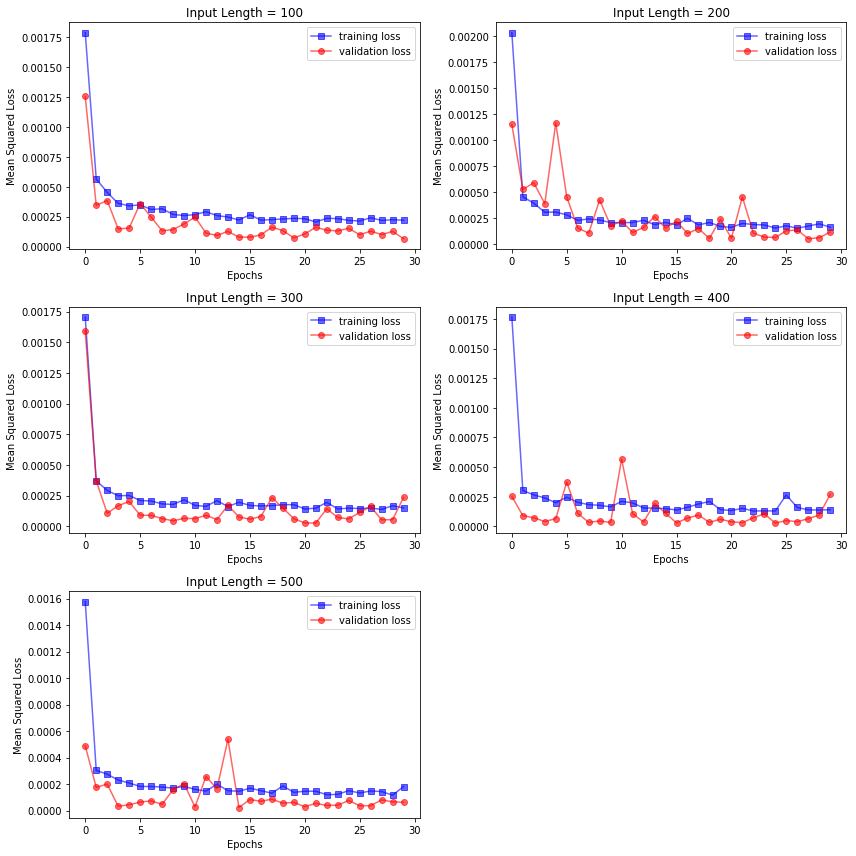

In [14]:
plot_learning_curves(loss_history, title_prefix='Input Length')

# Uniform H

In this section, $H$ is generated from a uniform distribution $\mathcal{U}([0, 0.5])$

In [15]:
T = 1
n_timesteps = 500
n_paths = 5000

Hs = generating_H(how='uniform')
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_data(Hs, 'rbergomi', n_paths, n_timesteps, T)

In [16]:
kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

report, loss_history = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test, 
                                 kernel_size, pool_size, leaky_rate, batch_size, n_epochs)

2019-04-14 01:56:54,480 - INFO - Performing paths of 100 time steps
2019-04-14 01:56:54,755 - INFO - Running CNN
2019-04-14 01:59:01,327 - INFO - Running Least Squares
2019-04-14 01:59:26,146 - INFO - Performing paths of 200 time steps
2019-04-14 01:59:26,405 - INFO - Running CNN
2019-04-14 02:02:29,325 - INFO - Running Least Squares
2019-04-14 02:03:00,624 - INFO - Performing paths of 300 time steps
2019-04-14 02:03:00,897 - INFO - Running CNN
2019-04-14 02:07:14,847 - INFO - Running Least Squares
2019-04-14 02:07:50,026 - INFO - Performing paths of 400 time steps
2019-04-14 02:07:50,292 - INFO - Running CNN
2019-04-14 02:13:09,047 - INFO - Running Least Squares
2019-04-14 02:13:45,903 - INFO - Performing paths of 500 time steps
2019-04-14 02:13:46,150 - INFO - Running CNN
2019-04-14 02:20:13,734 - INFO - Running Least Squares


In [17]:
report

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
Input length,,,,,,,
100,0.0141866,0.0900202,125.872,0.970151,0.239835,1.32261,20.9523
200,0.0084574,0.051556,181.922,1.25365,0.237976,1.36794,27.4306
300,0.0101654,0.0626448,252.6,1.61894,0.237361,1.38267,31.3292
400,0.00772046,0.0352416,317.054,1.96328,0.237243,1.38926,33.0307
500,0.00587763,0.0306373,385.484,2.34268,0.236999,1.39227,36.6639


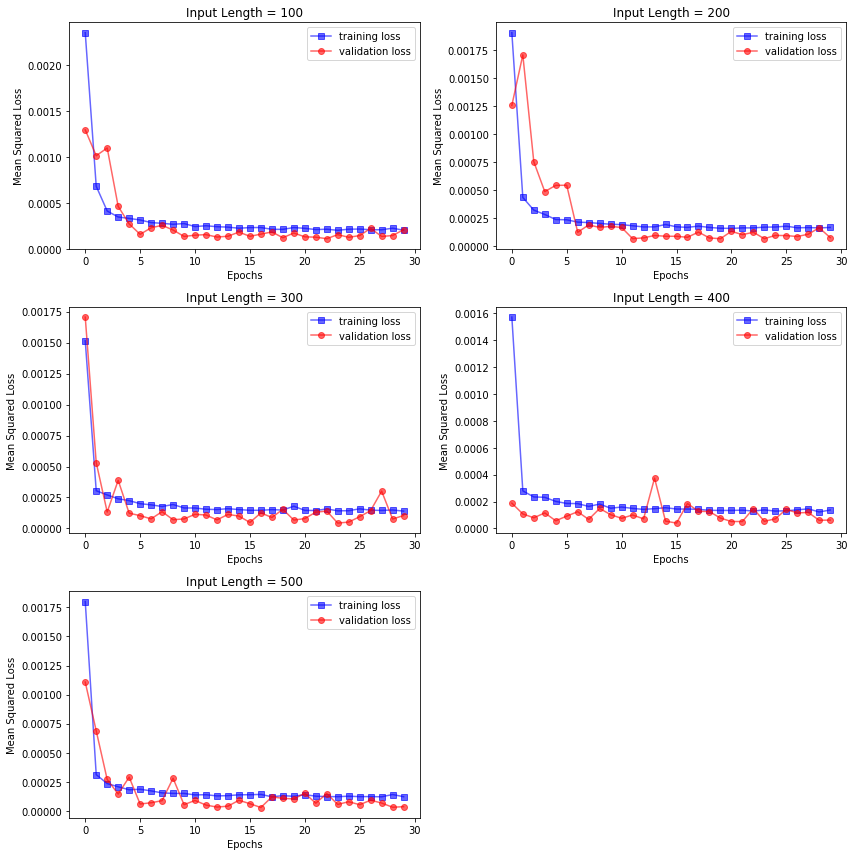

In [18]:
plot_learning_curves(loss_history, title_prefix='Input Length')

# Beta H

In this section $H$ is generated from a $Beta(1, 9)$ distribution

In [19]:
T = 1
n_timesteps = 500
n_paths = 5000

Hs = generating_H(how='beta')
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_data(Hs, 'rbergomi', n_paths, n_timesteps, T)

In [20]:
kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

report, loss_history = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test, 
                                 kernel_size, pool_size, leaky_rate, batch_size, n_epochs)

2019-04-14 02:21:04,316 - INFO - Performing paths of 100 time steps
2019-04-14 02:21:04,579 - INFO - Running CNN
2019-04-14 02:23:12,599 - INFO - Running Least Squares
2019-04-14 02:23:39,045 - INFO - Performing paths of 200 time steps
2019-04-14 02:23:39,303 - INFO - Running CNN
2019-04-14 02:26:43,516 - INFO - Running Least Squares
2019-04-14 02:27:13,471 - INFO - Performing paths of 300 time steps
2019-04-14 02:27:13,719 - INFO - Running CNN
2019-04-14 02:31:29,128 - INFO - Running Least Squares
2019-04-14 02:32:02,033 - INFO - Performing paths of 400 time steps
2019-04-14 02:32:02,287 - INFO - Running CNN
2019-04-14 02:37:21,947 - INFO - Running Least Squares
2019-04-14 02:38:00,869 - INFO - Performing paths of 500 time steps
2019-04-14 02:38:01,313 - INFO - Running CNN
2019-04-14 02:44:30,434 - INFO - Running Least Squares


In [21]:
report

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
Input length,,,,,,,
100,0.00685897,0.254342,127.154,1.12366,0.230811,5.16965,22.6674
200,0.00731717,0.188715,183.139,1.33005,0.232453,5.3745,26.1697
300,0.00657143,0.169752,253.875,1.77817,0.23306,5.44426,29.1003
400,0.00455805,0.141957,317.782,2.1287,0.233354,5.47545,35.1899
500,0.00489703,0.182161,387.04,2.52183,0.233479,5.48848,36.6896


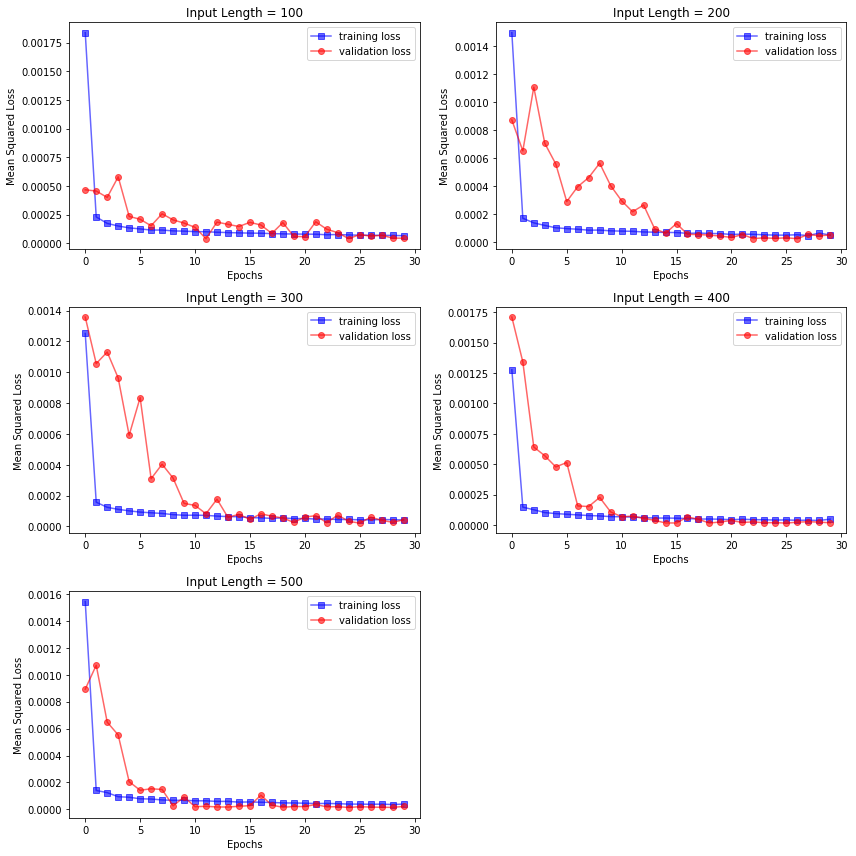

In [22]:
plot_learning_curves(loss_history, title_prefix='Input Length')

# Robustness test: discrete H, changing $\eta$ 

In this section, we allow $\eta$ to vary, instead of setting it fixed to 1 as above. $H$ is fixed with discretized values.

In [23]:
T = 1
n_timesteps = 100
n_paths = 5000

Hs = generating_H(how='discretized')

etas = [0.25, 0.8, 1.3, 2.5]

kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

report_eta = pd.DataFrame(columns=['RMSE(CNN)', 'MRE(CNN)', 'Training Time (seconds)', 'Test Time (seconds)', 
                                   'RMSE(LS)', 'MRE(LS)', 'Time (seconds)'], index=etas)
report_eta.index.name = 'eta'

loss_history_eta = {}
for eta in etas:
    logging.info("Perfoming paths of eta = {}".format(eta))
    X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_data(Hs, 'rbergomi', n_paths, n_timesteps, T, eta)
    report, loss_history = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                                     kernel_size, pool_size, leaky_rate, batch_size, n_epochs, time_steps=[100])
    report_eta.loc[eta, :] = report.iloc[0, :]
    loss_history_eta[eta] = loss_history[100]

2019-04-14 02:45:11,738 - INFO - Perfoming paths of eta = 0.25
2019-04-14 02:45:12,269 - INFO - Performing paths of 100 time steps
2019-04-14 02:45:12,509 - INFO - Running CNN
2019-04-14 02:47:22,489 - INFO - Running Least Squares
2019-04-14 02:47:47,076 - INFO - Perfoming paths of eta = 0.8
2019-04-14 02:47:47,724 - INFO - Performing paths of 100 time steps
2019-04-14 02:47:48,243 - INFO - Running CNN
2019-04-14 02:50:01,361 - INFO - Running Least Squares
2019-04-14 02:50:27,119 - INFO - Perfoming paths of eta = 1.3
2019-04-14 02:50:27,632 - INFO - Performing paths of 100 time steps
2019-04-14 02:50:27,888 - INFO - Running CNN
2019-04-14 02:52:39,944 - INFO - Running Least Squares
2019-04-14 02:53:05,001 - INFO - Perfoming paths of eta = 2.5
2019-04-14 02:53:05,534 - INFO - Performing paths of 100 time steps
2019-04-14 02:53:05,782 - INFO - Running CNN
2019-04-14 02:55:19,024 - INFO - Running Least Squares


In [24]:
report_eta

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
eta,,,,,,,
0.25,0.0120955,0.0395758,128.922,1.29487,0.20957,0.756238,20.7056
0.80,0.01622,0.0691422,132.129,1.50298,0.210914,0.765922,21.8895
1.30,0.0156615,0.0656553,130.891,1.41821,0.211446,0.765788,21.1447
2.50,0.0126341,0.0490361,132.034,1.45233,0.212003,0.760763,22.7412


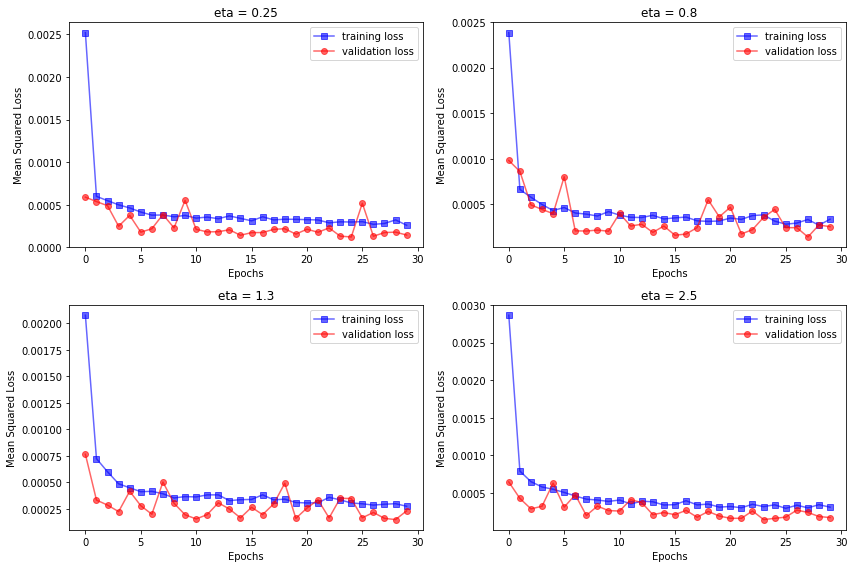

In [25]:
plot_learning_curves(loss_history_eta, title_prefix='eta')

# Robustness Test: fBm

In this section, we use fBm processes instead of rBergomi processses, discretized $H$

In [26]:
T = 1
n_timesteps = 100
n_paths = 5000

kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

samplers = ['discretized', 'uniform', 'beta']
report_fbm = pd.DataFrame(columns=['RMSE(CNN)', 'MRE(CNN)', 'Training Time (seconds)', 'Test Time (seconds)', 
                                   'RMSE(LS)', 'MRE(LS)', 'Time (seconds)'], index=samplers)
report_fbm.index.name = 'H sampler'

loss_history_fbm = {}

for sampler in samplers:
    logging.info("Performing H sampler: {}".format(sampler))
    Hs = generating_H(how=sampler)
    X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_data(Hs, 'fbm', n_paths, n_timesteps, T)

    report, loss_history = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test, 
                                     kernel_size, pool_size, leaky_rate, batch_size, n_epochs, time_steps=[100])
    report_fbm.loc[sampler, :] = report.iloc[0, :]
    loss_history_fbm[sampler] = loss_history[100]

2019-04-14 02:55:46,288 - INFO - Performing H sampler: discretized
2019-04-14 02:55:47,635 - INFO - Performing paths of 100 time steps
2019-04-14 02:55:47,898 - INFO - Running CNN
2019-04-14 02:58:00,818 - INFO - Running Least Squares
2019-04-14 02:58:25,614 - INFO - Performing H sampler: uniform
2019-04-14 02:58:27,234 - INFO - Performing paths of 100 time steps
2019-04-14 02:58:27,481 - INFO - Running CNN
2019-04-14 03:00:40,809 - INFO - Running Least Squares
2019-04-14 03:01:05,934 - INFO - Performing H sampler: beta
2019-04-14 03:01:07,527 - INFO - Performing paths of 100 time steps
2019-04-14 03:01:07,775 - INFO - Running CNN
2019-04-14 03:03:21,554 - INFO - Running Least Squares


In [27]:
report_fbm

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
H sampler,,,,,,,
discretized,0.0160114,0.0622565,131.682,1.49942,0.209574,0.755586,20.8961
uniform,0.0119476,0.0593175,132.05,1.52293,0.147933,0.613963,21.2382
beta,0.0160725,0.108108,132.471,1.55352,0.0963469,0.642579,22.5397


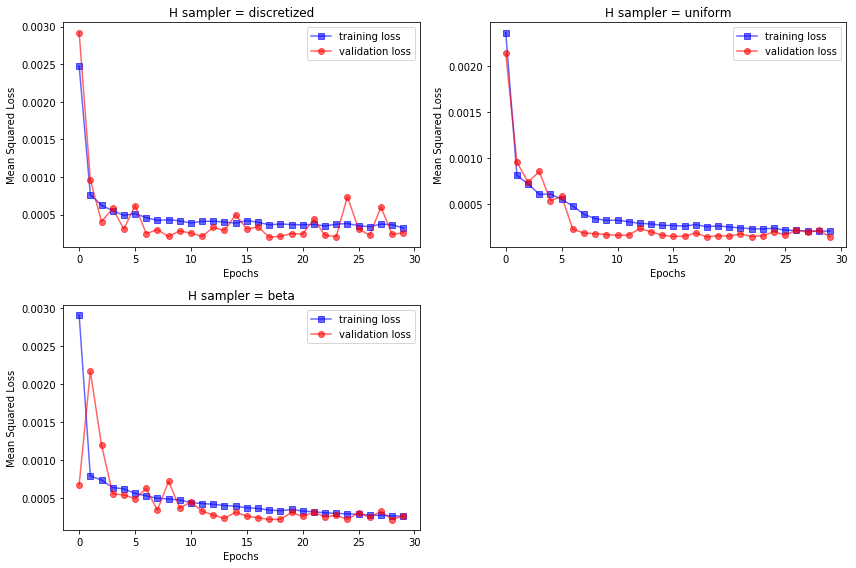

In [28]:
plot_learning_curves(loss_history_fbm, title_prefix='H sampler')

# Robustness Test: random $\eta$ and $H$

In this section, we allow both $\eta$ and $H$ to vary during the sample generation.

In [29]:
T = 1
n_timesteps = 100
n_paths = 25000

kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

logging.info("Generating paths with random eta and H")
paths, labels, etas = generating_rBergomi_random(n_paths)
X_train, X_val, X_test, Y_train, Y_val, Y_test = shuffle_split_data(paths, labels)

report, loss_history = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test, 
                                 kernel_size, pool_size, leaky_rate, batch_size, n_epochs, time_steps=[100])

2019-04-14 03:03:48,452 - INFO - Generating paths with random eta and H
2019-04-14 03:33:49,000 - INFO - Performing paths of 100 time steps
2019-04-14 03:33:49,260 - INFO - Running CNN
2019-04-14 03:36:03,022 - INFO - Running Least Squares


In [30]:
report

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
Input length,,,,,,,
100,0.0399457,2.22361,132.479,1.54069,0.129404,7.30693,22.448


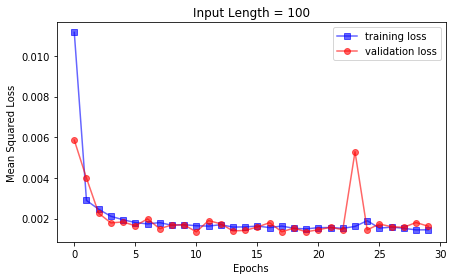

In [31]:
plot_learning_curves(loss_history, title_prefix='Input Length')

# Learning $\eta$ and $H$

In this section, we try to make the CNN to predict $H$ and $\eta$ at the same time.

In [32]:
T = 1
n_timesteps = 100
n_paths = 25000

logging.info("Generating paths with random eta and H")
paths, Hs, etas = generating_rBergomi_random(n_paths)
labels = np.column_stack((Hs, etas))
X_train, X_val, X_test, Y_train, Y_val, Y_test = shuffle_split_data(paths, labels)
logging.info("Data prepared")

2019-04-14 03:36:29,532 - INFO - Generating paths with random eta and H
2019-04-14 04:06:01,220 - INFO - Data prepared


In [33]:
kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

report = pd.DataFrame(columns=['H-RMSE(CNN)', 'eta-RMSE(CNN)', 'H-MRE(CNN)', 'eta-MRE(CNN)', 'Training Time (seconds)', 
                               'Test Time (seconds)', 'H-RMSE(LS)', 'eta-RMSE(LS)', 'H-MRE(LS)', 'eta-MRE(LS)', 
                               'Time (seconds)'], index=[100])
report.index.name = 'Input length'
loss_history = {}

start_time = time.time()
model = build_nn(n_timesteps, kernel_size, pool_size, leaky_rate, output_length=2)
model.compile(optimizer='adam', loss='mean_squared_error')

logging.info("Running CNN")
early_stopping = EarlyStopping(monitor='val_loss', patience=n_epochs, verbose=0, 
                               mode='auto', restore_best_weights=False)
cnn_train = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, 
                      validation_data=(X_val, Y_val), callbacks=[early_stopping])

cnn_train_time = time.time() - start_time
report.loc[100, 'Training Time (seconds)'] = cnn_train_time
start_time = time.time()

cnn_pred = model.predict(X_test)
cnn_test_time = time.time() - start_time
report.loc[100, 'Test Time (seconds)'] = cnn_test_time
report.loc[100, ['H-RMSE(CNN)', 'eta-RMSE(CNN)']] = np.sqrt(np.mean(np.power(cnn_pred-Y_test, 2), axis=0))
report.loc[100, ['H-MRE(CNN)', 'eta-MRE(CNN)']] = np.mean(np.abs(cnn_pred-Y_test) / Y_test, axis=0)

loss_history[n_timesteps] = {
    'train_loss': cnn_train.history['loss'],
    'val_loss': cnn_train.history['val_loss']
}

logging.info("Running Least Squares")
start_time = time.time()
ls_pred = least_squares(X_test)
report.loc[100, 'Time (seconds)'] = time.time() - start_time
report.loc[100, ['H-RMSE(LS)', 'eta-RMSE(LS)']] = np.sqrt(np.mean(np.power(ls_pred-Y_test, 2), axis=0))
report.loc[100, ['H-MRE(LS)', 'eta-MRE(LS)']] = np.mean(np.abs(ls_pred-Y_test) / Y_test, axis=0)


2019-04-14 04:06:01,525 - INFO - Running CNN
2019-04-14 04:08:15,459 - INFO - Running Least Squares


In [34]:
report

,H-RMSE(CNN),eta-RMSE(CNN),H-MRE(CNN),eta-MRE(CNN),Training Time (seconds),Test Time (seconds),H-RMSE(LS),eta-RMSE(LS),H-MRE(LS),eta-MRE(LS),Time (seconds)
Input length,,,,,,,,,,,
100,0.0388991,0.942251,1.41129,0.446254,132.628,1.57806,0.0534849,1.72317,1.35585,1.00425,20.7066


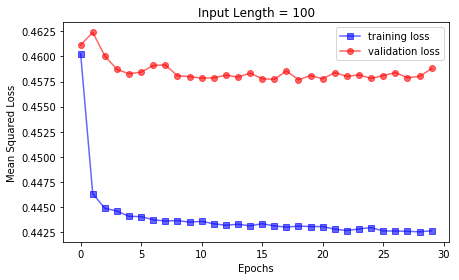

In [35]:
plot_learning_curves(loss_history, title_prefix='Input Length')